# 1. Simulating an exponential integrate-and-fire neuron

The exponential integrate-and-fire (EIF) model represents the membrane potential by:
$\tau_m \frac{dV}{dt} = -(V - V_{\text{rest}}) + \Delta_T \exp\!\left(\frac{V - V_T}{\Delta_T}\right) + R I_0 \quad (1)$


In [36]:
# constants
V_rest = -70 # mV
V_thresh = 0 # mV
R = 1 # G Ohms
V_T = -50 # mV
sharp = 2 # mV
tau_m = 10 # ms
dt = 0.01 # ms

## a)
We will plot the right hand side of (1) over the range $-80 \leq V \leq -40$.

In [37]:
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Change in Membrane Potential for EIF Neuron')

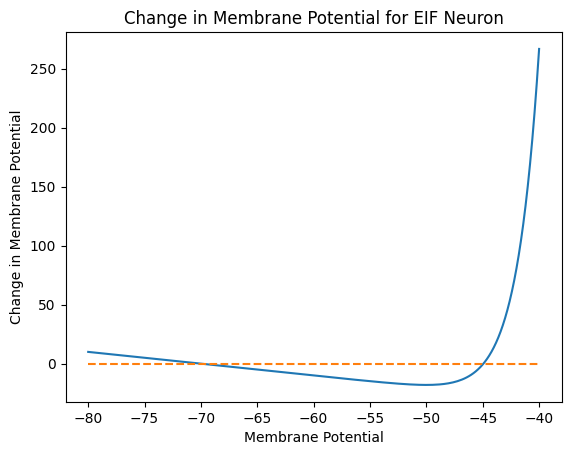

In [38]:
precision= 200
xs = np.linspace(-80,-40, precision)

def EIF_RHS(V, V_rest, sharp, V_T, I_0=0):
  return -(V - V_rest) + sharp * np.exp((V-V_T)/sharp) + I_0

ys = EIF_RHS(xs, V_rest, sharp, V_T)
plt.plot(xs, ys)

# plot a line at y = 0
y_0 = np.zeros(precision)
plt.plot(xs, y_0, '--')

plt.xlabel("Membrane Potential")
plt.ylabel("Change in Membrane Potential")
plt.title("Change in Membrane Potential for EIF Neuron")

$f(V) = 0$ around the values of $V = -70$ and $V = -45$. At $V=-70$, the membrane is at its resting potential so it is stable at that voltage. At $V=-45$ the neuron is passed the $V_T$ value so the input to the exponential function is positive and growing so the neuron's membrane potential is spiking.

## b)


In [39]:
voltages = np.arange(-50,-40,2)
T = np.arange(0,50,dt) # ms

membrane_evolutions = []

for i in range(voltages.size):
    V_init = voltages[i]
    membrane_potential = [V_init]
    for j in range(1,T.size):
        new_membrane_potential = membrane_potential[j-1] + dt*EIF_RHS(membrane_potential[j-1], V_rest, sharp, V_T)
        if new_membrane_potential >= V_thresh:
            membrane_potential.append(V_thresh)
        else:
            membrane_potential.append(new_membrane_potential)
    membrane_evolutions.append(membrane_potential)

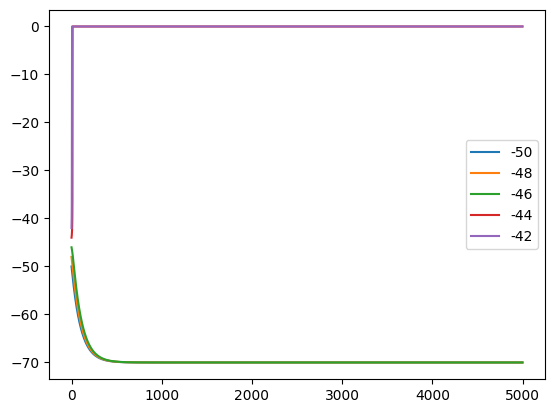

In [40]:
# plot the evolution of the membrane potential for different initial voltages
for i in range(len(membrane_evolutions)):
    plt.plot(membrane_evolutions[i], label=f"{voltages[i]}")
plt.legend()

An initial voltage of greater than $-45$ mV leads V to cross the threshold. This makes sense when we consider the first graph that shows that any membrane voltage above this will enter into a positive feedback loop and spike.

## c)
Investigating external current.

In [43]:
current_values = np.arange(18,22,1)
T_100ms = np.arange(0,100,dt)

potentials = []

for i in range(current_values.size):
    I_0 = current_values[i]
    membrane_potential = [V_rest]
    flag = False
    for j in range(1,T_100ms.size):
        new_membrane_potential = membrane_potential[j-1] + dt*EIF_RHS(membrane_potential[j-1], V_rest, sharp, V_T, I_0)
        if new_membrane_potential > V_thresh:
            membrane_potential.append(V_thresh)
            flag = True
        elif flag:
            membrane_potential.append(V_rest)
            flag = False
        else:
            membrane_potential.append(new_membrane_potential)
    potentials.append(membrane_potential)

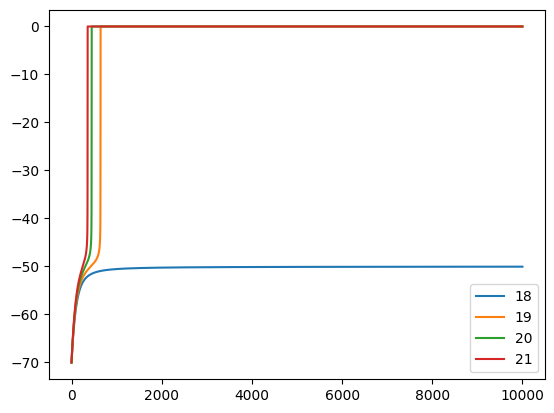

In [44]:
# plot the evolution of the membrane potential for different initial voltages
for i in range(len(potentials)):
    plt.plot(potentials[i], label=f"{current_values[i]}")
plt.legend()

It appears that we need more than 18 nA but less than 19 nA to generate a spike.